# Assignment Name: Geospatial Standards and Formats

## Description

In this assignment, we perform a series of geospatial data analyses to extract insights from datasets pertaining to Aboriginal Lands, flood extents, and roads within York and Sunbury Counties. We also investigate the area around the Fredericton International Airport, analyzing road networks in relation to a buffer zone created around the airport's location.

In [65]:
# Import packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## PART A. Read and Query Data

### 1. What is (are) the name(s) of the Aboriginal Lands (AL_TA_NB_2_143_eng) within York County?

First, we read the necessary shapefiles containing the Aboriginal Lands data and the county boundaries.

In [66]:
# Read the shapefiles containing Aboriginal Lands and County Boundaries
gdf = gpd.read_file("./Assignment 1 Data/AL_TA_NB_2_143_eng.shp")
gdf_county = gpd.read_file("./Assignment 1 Data/geonb_county.shp")

Displaying all columns of the DataFrame for a comprehensive analysis.

In [67]:
# Set pandas to display all columns for a complete overview of the data
pd.set_option('display.max_columns', None)

Ensuring both datasets have the same CRS for accurate geometric operations.

In [68]:
# Ensure the Aboriginal Lands data is in the same CRS as the County data for accurate spatial analysis
gdf = gdf.to_crs(gdf_county.crs)

Filtering out the specific area of interest, which is York County.

In [69]:
# Define a condition for selecting York County from the county DataFrame
cond1 = gdf_county['ENG_NAME'] == 'York'
york_county = gdf_county[cond1]

Performing a spatial intersection to find Aboriginal Lands within York County.

In [70]:
# Use a spatial overlay to find the intersection of Aboriginal Lands and York County
aboriginal_lands_in_york = gpd.overlay(gdf, york_county, how='intersection')

In [71]:
# Print the names of Aboriginal Lands within York County
print(aboriginal_lands_in_york['NAME1'])

0     KINGSCLEAR INDIAN RESERVE NO. 6
1    ST. MARY'S INDIAN RESERVE NO. 24
2         DEVON INDIAN RESERVE NO. 30
Name: NAME1, dtype: object


### 2. In the FloodExtent file, what is the maximum water level recorded?

First, we load the FloodExtent shapefile data into a GeoDataFrame for analysis.

In [72]:
# Read the FloodExtent shapefile into a GeoDataFrame
gdf_flood = gpd.read_file("./Assignment 1 Data/Flood_Extent_2018_LowerSaintJohn.shp")

By querying the Water_Leve column, we can extract the highest recorded water level.

In [73]:
# Calculate the maximum value in the 'Water_Leve' column to find the maximum water level
max_water_level = gdf_flood['Water_Leve'].max()

In [74]:
# Output the maximum water level recorded in the dataset
print(f"Maximum Water Level Recorded: {max_water_level} meters")

Maximum Water Level Recorded: 10.7 meters


### 3. In the FloodExtent file, what is the maximum water level recorded in Sunbury County (geonb_county)?

To ensure spatial compatibility, the FloodExtent data is reprojected to match the coordinate reference system of the county data.

In [75]:
# Reproject the FloodExtent data to match the CRS of the county data
gdf_flood = gdf_flood.to_crs(gdf_county.crs)

A condition is set to filter out the Sunbury County area from the county dataset.

In [76]:
# Create a condition to select only the rows corresponding to Sunbury County
cond2 = gdf_county['ENG_NAME'] == 'Sunbury'
sunbury_county = gdf_county[cond2]

We use a spatial join to isolate flood records within the bounds of Sunbury County.

In [77]:
# Use a spatial join to find the flood extents within Sunbury County
flood_in_sunbury = gpd.sjoin(gdf_flood, sunbury_county, how='inner', predicate='intersects')

The maximum water level within the county's area is then calculated.

In [78]:
# Calculate the maximum water level in Sunbury County
max_water_level_sunbury = flood_in_sunbury['Water_Leve'].max()

In [79]:
# Display the maximum water level found in Sunbury County
print(f"Maximum Water Level Recorded in Sunbury County: {max_water_level_sunbury} meters")

Maximum Water Level Recorded in Sunbury County: 7.4 meters


### 4. What is the total Length of Roads in Sunbury and York counties (in kilometres, rounded to 2 decimals)?

We begin by loading the data for the roads in Sunbury and York counties from the provided shapefile.

In [80]:
# Load the roads data from the shapefile
gdf_SunburyYork_roads = gpd.read_file("./Assignment 1 Data/geonb_roads_SunburyYork.shp")

A filter is created to select only the roads in the counties of interest.

In [81]:
# Define the counties of interest
counties_of_interest = ['Sunbury', 'York']

# Filter the roads data to include only the counties of interest
cond3 = gdf_SunburyYork_roads['COUNTY'].isin(counties_of_interest)

The lengths of the roads are calculated and added as a new column in the GeoDataFrame.

In [82]:
# Use .loc to create a new DataFrame based on the condition
gdf_selected_counties = gdf_SunburyYork_roads.loc[cond3].copy()

# Calculate the length of roads in kilometers
gdf_selected_counties['road_length_km'] = gdf_selected_counties['geometry'].length / 1000

The total road lengths are aggregated by county and displayed.

In [83]:
# Aggregate the total road lengths by county
total_length_by_county = gdf_selected_counties.groupby('COUNTY')['road_length_km'].sum()

In [84]:
# Print the total road lengths for each county, rounded to two decimal places
for county, length in total_length_by_county.items():
    print(f'Total Length of Roads in {county} County: {round(length, 2)} km')

Total Length of Roads in Sunbury County: 1103.08 km
Total Length of Roads in York County: 3045.49 km


### 5. Select all the roads from GeoNB Roads_SunburyYork which have a Street name of “Waterloo Row”.

<h3> a. Print how many roads are selected. </h3>

We begin by identifying all the roads with the name "Waterloo Row" in the GeoNB Roads_SunburyYork dataset.

In [85]:
# Filter the GeoDataFrame to select roads with the street name "Waterloo Row"
waterloo_roads = gdf_SunburyYork_roads[gdf_SunburyYork_roads['STREETNAME'] == 'Waterloo Row']

Next, we count how many road segments are named "Waterloo Row".

In [86]:
# Output the number of selected roads
num_waterloo_roads = len(waterloo_roads)
print(f'Number of roads selected with Street name "Waterloo Row": {num_waterloo_roads}')

Number of roads selected with Street name "Waterloo Row": 2


<h3> b. Dissolve all roads with the name Waterloo Row into 1 feature. </h3>

To analyze the cumulative shape of these roads, we dissolve all segments into one feature.

In [87]:
# Dissolve all selected road segments into a single feature
dissolved_waterloo_roads = waterloo_roads.dissolve(by='STREETNAME')

<h3> c. Write the dissolved roads to a GeoJSON file. </h3>

Finally, we save the dissolved road feature as a GeoJSON file.

In [88]:
# Define the output filename for the GeoJSON file
GEOJSON_output_filename = 'dissolved_waterloo_roads.geojson'

# Save the dissolved roads as a GeoJSON file
dissolved_waterloo_roads.to_file(GEOJSON_output_filename, driver='GeoJSON')

# Confirm the action
print(f"Dissolved roads written to file: {GEOJSON_output_filename}")

Dissolved roads written to file: dissolved_waterloo_roads.geojson


## PART B. Create Data and Buffer

### 6. Create a Point Feature at Fredericton International Airport: 45.87286, -66.52982 (EPSG:4326)

 we define the geographic location of the Fredericton International Airport using its latitude and longitude coordinates.

In [89]:
# Define the longitude and latitude coordinates for Fredericton International Airport
airport_coords = (-66.52982, 45.87286)

Using the coordinates, we create a Point object and then generate a GeoDataFrame to represent the airport's location.

In [90]:
# Create a Point object using the defined coordinates
airport_point = Point(airport_coords)

# Create a GeoDataFrame with the Point object and assign the appropriate CRS (EPSG:4326)
Fred_Airport_df = gpd.GeoDataFrame(geometry=[airport_point], crs='EPSG:4326')

In [91]:
# Display the GeoDataFrame containing the airport point feature
print(Fred_Airport_df)

                     geometry
0  POINT (-66.52982 45.87286)


### 7. What is the coordinate system used in the GeoNB Roads_SunburyYork file?

In order to perform accurate spatial analysis, it is essential to understand the coordinate system in which the spatial data is represented. Here, we access the CRS information of the GeoNB Roads_SunburyYork dataset.

In [92]:
# Retrieve the CRS information from the GeoDataFrame
gdf_SunburyYork_roads_crs_info = gdf_SunburyYork_roads.crs

With the CRS attribute accessed, we print out the details to understand the underlying coordinate system used for the roads dataset.

In [93]:
# Print the CRS information for the GeoNB Roads_SunburyYork file
print(f"Coordinate System (CRS) used in the GeoNB Roads_SunburyYork file: \n{gdf_SunburyYork_roads_crs_info}")

Coordinate System (CRS) used in the GeoNB Roads_SunburyYork file: 
PROJCS["NAD_1983_CSRS_New_Brunswick_Stereographic",GEOGCS["GCS_North_American_1983_CSRS",DATUM["D_North_American_1983_CSRS",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",46.5],PARAMETER["central_meridian",-66.5],PARAMETER["scale_factor",0.999912],PARAMETER["false_easting",2500000],PARAMETER["false_northing",7500000],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


### 8. Project the Fredericton International Airport point (created in step 6) to match GeoNBRoads_SunburyYork.

To ensure compatibility for spatial analysis, we need to project the Fredericton International Airport point to match the coordinate reference system of the GeoNB Roads_SunburyYork dataset.

In [94]:
# Reproject the Fredericton International Airport point to match the CRS of the roads dataset
Fred_Airport_df_projected = Fred_Airport_df.to_crs(gdf_SunburyYork_roads.crs)

After reprojecting, we can display the GeoDataFrame to confirm that the airport point has been correctly transformed to the new CRS.

In [95]:
# Print the GeoDataFrame with the reprojected airport point to verify its CRS
print(Fred_Airport_df_projected)

                          geometry
0  POINT (2497684.823 7430295.107)


### 9. Create a 5km buffer around the Fredericton International Airport point

A buffer zone is defined as an area that extends outward from the airport's location, allowing for spatial analysis of features within that area.

In [96]:
# Define the buffer radius in meters
buffer_radius_meters = 5000  # 5 km expressed in meters

# Create the buffer around the airport point
buffer_5km = Fred_Airport_df_projected.buffer(buffer_radius_meters)

With the buffer geometry created, we encapsulate it within a GeoDataFrame for compatibility with geospatial operations.

In [97]:
# Create a GeoDataFrame from the buffer geometry with the same CRS as the airport point
buffer_5km_df = gpd.GeoDataFrame(geometry=buffer_5km, crs=Fred_Airport_df_projected.crs)

Visualization aids in the interpretation of the spatial relationship between the airport and the surrounding area.

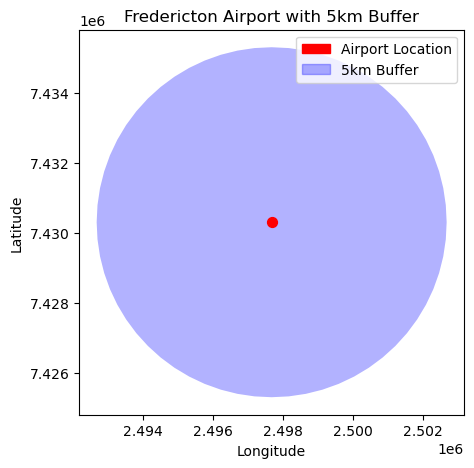

In [98]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the buffer as a blue transparent layer
buffer_5km_df.plot(ax=ax, color='blue', alpha=0.3)

# Overlay the airport location as a red point
Fred_Airport_df_projected.plot(ax=ax, color='red', marker='o', markersize=50)

# Create custom legend handles for the airport location and buffer
airport_patch = mpatches.Patch(color='red', label='Airport Location')
buffer_patch = mpatches.Patch(color='blue', alpha=0.3, label='5km Buffer')

# Add the custom legend to the plot
ax.legend(handles=[airport_patch, buffer_patch])

# Set the title and axis labels
ax.set_title('Fredericton Airport with 5km Buffer')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()

### 10. Query to find out how many roads intersect this buffer

<h3> a. Print how many roads of each ST_TYPE and the sum total of roads. </h3>

First, we identify and count the roads that intersect with the 5km buffer around the airport, categorizing them by their street type (ST_TYPE).

In [99]:
# Identify roads that intersect with the buffer
intersections = gdf_SunburyYork_roads[gdf_SunburyYork_roads.geometry.intersects(buffer_5km_df.unary_union)]

# Group intersecting roads by their street type and count
roads_count_by_type = intersections.groupby('ST_TYPE').size()

Print Counts by Street Type

In [100]:
# Print the number of roads for each street type
print("Number of roads by ST_TYPE:")
print(roads_count_by_type)

Number of roads by ST_TYPE:
ST_TYPE
Avenue        48
Boulevard      8
Circle         7
Court         64
Crescent      22
Cross          1
Drive         96
Highway       71
Lane          26
None           8
Park           2
Ramp          17
Road         112
Street       153
Way            5
dtype: int64


Calculate and Print Total Number of Roads

In [101]:
# Calculate the total number of intersecting roads
total_roads = roads_count_by_type.sum()

# Print the total number of intersecting roads
print("\nTotal number of roads intersecting the buffer:", total_roads)


Total number of roads intersecting the buffer: 640


<h3> b. Plot the roads, the airport location and the buffer. </h3>

We then create a visual representation of the intersecting roads, the airport location, and the buffer zone.

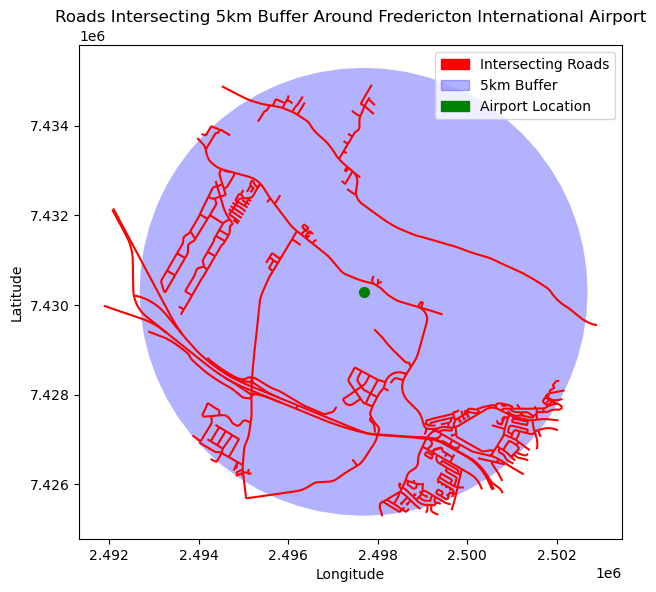

In [102]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plotting the intersecting roads, buffer, and airport location
fig, ax = plt.subplots(figsize=(7, 7))

# Plot intersecting roads in red
intersections.plot(ax=ax, color='red', label='Intersecting Roads')

# Plot the 5km buffer around the airport in blue
buffer_5km_df.plot(ax=ax, color='blue', alpha=0.3)

# Plot the airport location as a green point
Fred_Airport_df_projected.plot(ax=ax, color='green', marker='o', markersize=50)

# Custom legend for the plot
roads_patch = mpatches.Patch(color='red', label='Intersecting Roads')
buffer_patch = mpatches.Patch(color='blue', alpha=0.3, label='5km Buffer')
airport_patch = mpatches.Patch(color='green', label='Airport Location')
ax.legend(handles=[roads_patch, buffer_patch, airport_patch])

# Set plot title and labels
ax.set_title('Roads Intersecting 5km Buffer Around Fredericton International Airport')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()

<h3> c. Write the output to a new Shapefile (and include in your submission). </h3>

Finally, we save the intersecting roads data to a shapefile for future use or analysis.

In [103]:
# Specify the filename for the new shapefile
output_filename = 'intersecting_roads.shp'

# Save intersecting roads to the shapefile
intersections.to_file(output_filename)

# Confirm the action
print(f"Intersecting roads data saved to file: {output_filename}")

Intersecting roads data saved to file: intersecting_roads.shp


### REFERENCES:

https://shapely.readthedocs.io/en/stable/manual.html 

https://geopandas.org/en/stable/docs/reference.html

https://pandas.pydata.org/docs/reference/groupby.html

https://pandas.pydata.org/docs/reference/frame.html